<a href="https://colab.research.google.com/github/aggelospsiris/Data-mining-and-Learning-Algorithms/blob/main/lstm/first.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import os

In [ ]:
#Add every csv into a dataframe and in every row add the date that is gonna be a crusial input for the lstm

### Demands ###

df_dmd = pd.DataFrame()
for file1 in os.listdir("/content/drive/MyDrive/Colab Notebooks/demand"):
    try:
        current_demand = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/demand/" + file1)
        current_demand["Date"] = pd.to_datetime(file1[0:8], format='%Y%m%d')
        df_dmd = df_dmd.append(current_demand, ignore_index=False)
    except:
        continue

df_dmd.Time = pd.to_datetime(df_dmd.Time)

### Sources ###

df_sources = pd.DataFrame()
for file2 in os.listdir("/content/drive/MyDrive/Colab Notebooks/sources"):
    try:
        current_source = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/sources/" + file2)
        current_source["Date"] = pd.to_datetime(file2[0:8], format='%Y%m%d')
        df_sources = df_sources.append(current_source, ignore_index=False)
    except:
        continue

df_sources.Time = pd.to_datetime(df_sources.Time)


In [ ]:
#As we can see from these results some files from the sources folder have empty values
#so our try,except block ignores the empty files
#So the two dataframes havent the same size so we are going to have a problem merging them
#I fix this issue by adding on more column to the dataframe thats is the date 
#So i am merging them by day AND time and not only time  
print(df_dmd.shape)
print(df_sources.shape)



(316744, 5)
(315641, 17)


In [ ]:
### Merge the two datasets ###
df3 = pd.merge(df_sources, df_dmd, on=["Time","Date"])
print(df3.shape)
print("------------------------------------------")
print(df3.head())


(316748, 20)
------------------------------------------
                 Time  Solar    Wind  Geothermal  Biomass  Biogas  \
0 2022-05-31 00:00:00    0.0  3952.0       971.0    214.0   178.0   
1 2022-05-31 00:00:00    0.0  3952.0       971.0    214.0   178.0   
2 2022-05-31 00:05:00    0.0  4037.0       971.0    215.0   178.0   
3 2022-05-31 00:10:00    0.0  4040.0       970.0    215.0   178.0   
4 2022-05-31 00:15:00    0.0  4055.0       971.0    218.0   178.0   

   Small hydro  Coal  Nuclear  Natural gas  Large hydro  Batteries  Imports  \
0        459.0  10.0   2282.0       2321.0       3906.0     -104.0   6846.0   
1        459.0  10.0   2282.0       2321.0       3906.0     -104.0   6846.0   
2        460.0  10.0   2283.0       2422.0       4093.0      -41.0   6427.0   
3        459.0  10.0   2282.0       2366.0       4230.0        4.0   6204.0   
4        457.0  10.0   2282.0       2321.0       4252.0       12.0   6079.0   

   Other       Date  Natural Gas  Large Hydro  Day ahe

In [ ]:
#'Large Hydro', 'Natural Gas' had nan values also the lstm has to guess the non renewable resources so i dont need them as input 
#So i am going to drop these columns
#Also the Day ahead forecast and the Hour ahead forecast are not useful nor as inputs not as outputs on the lstm
df3 = df3.drop(['Large Hydro', 'Natural Gas','Nuclear','Batteries','Day ahead forecast','Hour ahead forecast'], axis=1)
print(df3.head())

                 Time  Solar    Wind  Geothermal  Biomass  Biogas  \
0 2022-05-31 00:00:00    0.0  3952.0       971.0    214.0   178.0   
1 2022-05-31 00:00:00    0.0  3952.0       971.0    214.0   178.0   
2 2022-05-31 00:05:00    0.0  4037.0       971.0    215.0   178.0   
3 2022-05-31 00:10:00    0.0  4040.0       970.0    215.0   178.0   
4 2022-05-31 00:15:00    0.0  4055.0       971.0    218.0   178.0   

   Small hydro  Coal  Natural gas  Large hydro  Imports  Other       Date  \
0        459.0  10.0       2321.0       3906.0   6846.0    0.0 2019-04-10   
1        459.0  10.0       2321.0       3906.0   6846.0    0.0 2019-04-10   
2        460.0  10.0       2422.0       4093.0   6427.0    0.0 2019-04-10   
3        459.0  10.0       2366.0       4230.0   6204.0    0.0 2019-04-10   
4        457.0  10.0       2321.0       4252.0   6079.0    0.0 2019-04-10   

   Current demand  
0         21021.0  
1             NaN  
2         20900.0  
3         20913.0  
4         20841.0  


In [ ]:
#Now i have to convert date and time into a better input for my lstm 
#In a timestamp format is not gonna give any help to the lstm
#I need to convert it in a form that january is close to december and 23:55 is near to 00:05
#So i am using sin and cosine to format my values in a circle
#Also the year is not gonna be usufull so i am not keeping it
df3['month'] = df3.Date.dt.month
df3['day'] = df3.Date.dt.day
df3['hour'] = df3.Time.dt.hour
df3['minute'] = df3.Time.dt.minute
df3 = df3.drop(['Time','Date'],axis=1)

In [ ]:
df3.head()

,Solar,Wind,Geothermal,Biomass,Biogas,Small hydro,Coal,Natural gas,Large hydro,Imports,Other,Current demand,month,day,hour,minute
0,0.0,3952.0,971.0,214.0,178.0,459.0,10.0,2321.0,3906.0,6846.0,0.0,21021.0,4,10,0,0
1,0.0,3952.0,971.0,214.0,178.0,459.0,10.0,2321.0,3906.0,6846.0,0.0,NaN,4,10,0,0
2,0.0,4037.0,971.0,215.0,178.0,460.0,10.0,2422.0,4093.0,6427.0,0.0,20900.0,4,10,0,5
3,0.0,4040.0,970.0,215.0,178.0,459.0,10.0,2366.0,4230.0,6204.0,0.0,20913.0,4,10,0,10
4,0.0,4055.0,971.0,218.0,178.0,457.0,10.0,2321.0,4252.0,6079.0,0.0,20841.0,4,10,0,15


In [ ]:
#Converting the values into cos and sin values
# Month
df3['day_sin'] = np.sin(df3.month*(2.*np.pi/12))
df3['day_cos'] = np.cos(df3.month*(2.*np.pi/12))
# Day
df3['day_sin'] = np.sin(df3.day*(2.*np.pi/30))
df3['day_cos'] = np.cos(df3.day*(2.*np.pi/30))
# Hour
df3['hour_sin'] = np.sin(df3.hour*(2.*np.pi/24))
df3['hour_cos'] = np.cos(df3.hour*(2.*np.pi/24))
# Minute
df3['minute_sin'] = np.sin(df3.minute*(2.*np.pi/60))
df3['minute_cos'] = np.cos(df3.minute*(2.*np.pi/60))

df3 = df3.drop(['month',	'day',	'hour',	'minute'],axis=1)
df3 = df3[['Solar','Wind','Geothermal','Biomass','Biogas','Small hydro','Coal','Natural gas','Large hydro','Imports','Other',	'day_sin',	'day_cos',	'hour_sin',	'hour_cos',	'minute_sin',	'minute_cos', 'Current demand']]
#drop all the row that has at least one nan value
df3 = df3.dropna()
df3.head()


,Solar,Wind,Geothermal,Biomass,Biogas,Small hydro,Coal,Natural gas,Large hydro,Imports,Other,day_sin,day_cos,hour_sin,hour_cos,minute_sin,minute_cos,Current demand
0,0.0,3952.0,971.0,214.0,178.0,459.0,10.0,2321.0,3906.0,6846.0,0.0,0.866025,-0.5,0.0,1.0,0.000000,1.000000e+00,21021.0
2,0.0,4037.0,971.0,215.0,178.0,460.0,10.0,2422.0,4093.0,6427.0,0.0,0.866025,-0.5,0.0,1.0,0.500000,8.660254e-01,20900.0
3,0.0,4040.0,970.0,215.0,178.0,459.0,10.0,2366.0,4230.0,6204.0,0.0,0.866025,-0.5,0.0,1.0,0.866025,5.000000e-01,20913.0
4,0.0,4055.0,971.0,218.0,178.0,457.0,10.0,2321.0,4252.0,6079.0,0.0,0.866025,-0.5,0.0,1.0,1.000000,6.123234e-17,20841.0
5,0.0,4075.0,971.0,217.0,178.0,432.0,10.0,2147.0,4233.0,6032.0,0.0,0.866025,-0.5,0.0,1.0,0.866025,-5.000000e-01,20601.0


In [ ]:
########## Normalization of the data ##################
#It will be beneficial now to normalize my data. 
#Having different features with widely different scales fed to my model 
#will cause the network to weight the features not equally. 
#This can cause a falsely prioritisation of some features over the others in the representation
from sklearn.preprocessing import StandardScaler
import numpy as np

# Read dataset 
dataset = pd.DataFrame(df3).to_numpy()
norm_dataset = StandardScaler().fit_transform(X=dataset)
norm_dataset[0:3]

array([[-8.21654429e-01,  1.45867732e+00,  6.89814487e-01,
        -2.16032978e+00, -2.29900086e+00,  2.15022430e-01,
        -8.83202723e-01, -1.43091183e+00,  1.45419971e+00,
         3.27674430e-01, -3.60330828e-02,  1.21616235e+00,
        -7.20293951e-01,  6.89406534e-05,  1.41280120e+00,
        -2.44543144e-05,  1.41247949e+00, -7.64844468e-01],
       [-8.21654429e-01,  1.52349861e+00,  6.89814487e-01,
        -2.13925839e+00, -2.29900086e+00,  2.16221533e-01,
        -8.83202723e-01, -1.40593360e+00,  1.59675382e+00,
         1.69480677e-01, -3.60330828e-02,  1.21616235e+00,
        -7.20293951e-01,  6.89406534e-05,  1.41280120e+00,
         7.07375661e-01,  1.22308917e+00, -7.89495050e-01],
       [-8.21654429e-01,  1.52578642e+00,  6.81417707e-01,
        -2.13925839e+00, -2.29900086e+00,  2.15022430e-01,
        -8.83202723e-01, -1.41978291e+00,  1.70119186e+00,
         8.52868660e-02, -3.60330828e-02,  1.21616235e+00,
        -7.20293951e-01,  6.89406534e-05,  1.41280120e

In [ ]:
# Split into input and output
X = norm_dataset[:, :-1]
Y = norm_dataset[:, -1]

from sklearn.model_selection import KFold
# Split the data to training and testing data 5-Fold
kfold = KFold(n_splits=5, shuffle=True)
rmseList = []
rrseList = []

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense,Bidirectional,LSTM
from keras import backend as K

for i, (train, test) in enumerate(kfold.split(X)):
    # Building the model
    model = Sequential()
    # Adding a Bidirectional LSTM layer
    model.add((LSTM(128,return_sequences=True, dropout=0.5, input_shape=( X[train].shape[1],1))))
    model.add(Bidirectional(LSTM(64, dropout=0.5)))
    model.add(Bidirectional(LSTM(32, dropout=0.5)))
    model.add(Dense(1))

    # Compile model
    def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=[rmse])

    # Fit model
    history = model.fit(X[train], Y[train],validation_data=(X[train], Y[train]),epochs=100, batch_size=200, verbose=0)

    # Evaluate model
    scores = model.evaluate(X[test], Y[test], verbose=0)
    rmseList.append(scores[0])
    print("Fold :", i, " RMSE:", scores[0])

print("RMSE: ", np.mean(rmseList))


KeyboardInterrupt: ignored

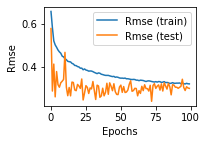

In [ ]:
#Plots
from matplotlib import pyplot

pyplot.figure(0)
pyplot.subplot(2, 2, 1)
pyplot.plot(history.history['loss'], label='Rmse (train)')
pyplot.plot(history.history['val_loss'], label='Rmse (test)')
pyplot.ylabel("Rmse")
pyplot.xlabel("Epochs")
pyplot.legend()
pyplot.show( )